# Risk Analysis

## Financial Statistics using Julia

### 16-17th Dec, 2025

#### Instructor: Sourish

**Notebook 5**

In [1]:
using YFinance, Dates, Plots,Statistics, StatsBase

# -----------------------------
# S&P 500 proxy: SPY
# -----------------------------
SnP500 = get_prices("SPY";
    startdt = Date("2015-01-01"),
    enddt   = today()
)

SnP500_adjclose = SnP500["adjclose"];


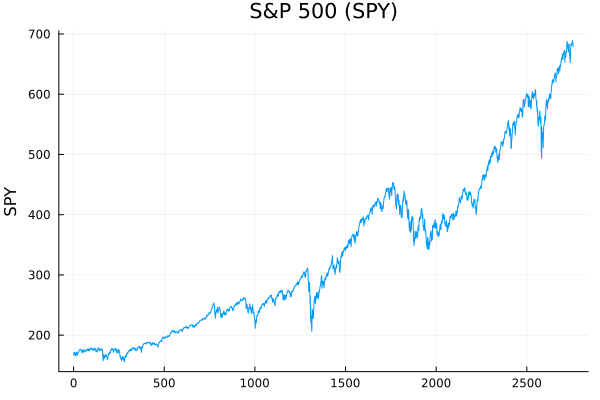

In [2]:
plot(SnP500_adjclose, ylabel = "SPY", title = "S&P 500 (SPY)",legend=:none)

In [3]:
# log-return (equivalent to as.numeric(diff(log(SnP.500))))
ln_rt = diff(log.(SnP500_adjclose)) |> collect;


In [4]:
r = ln_rt                  # log-returns
r2 = r .^ 2 ;               # squared log-returns


In [5]:
maxlag = 30

acf_r  = autocor(r,  0:maxlag)
acf_r2 = autocor(r2, 0:maxlag);


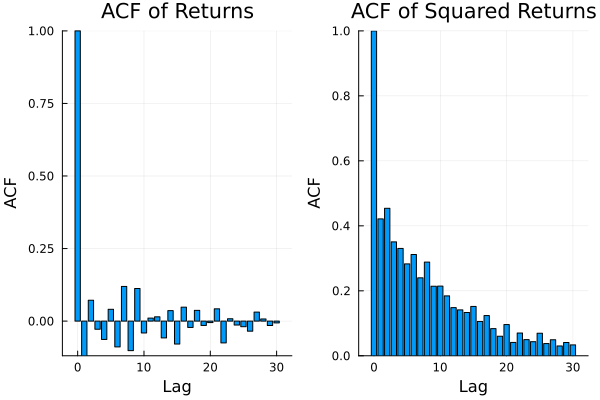

In [6]:
p1 = bar(0:maxlag, acf_r,
         xlabel = "Lag",
         ylabel = "ACF",
         title = "ACF of Returns",
         legend = false)

p2 = bar(0:maxlag, acf_r2,
         xlabel = "Lag",
         ylabel = "ACF",
         title = "ACF of Squared Returns",
         legend = false)

plot(p1, p2, layout = (1, 2))


In [7]:
VIX = get_prices("^VIX";
    startdt = Date("2015-01-01"),
    enddt   = today()
)

# Keys are Strings, not Symbols
VIX_close    = VIX["close"]
VIX_adjclose = VIX["adjclose"];


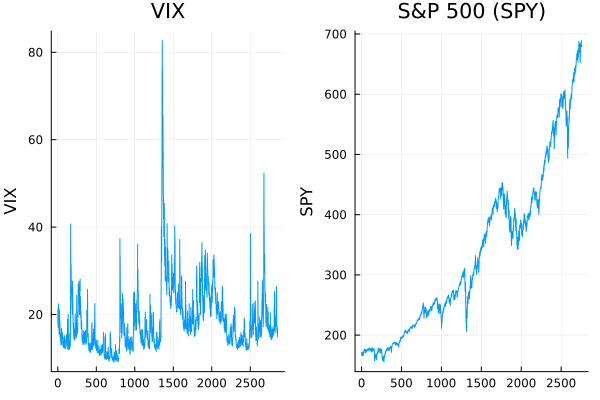

In [8]:
using Plots
# -----------------------------
# Plot (equivalent to par(mfrow=c(1,2)))
# -----------------------------
p1 = plot(VIX_adjclose, ylabel = "VIX", title = "VIX",legend=:none)
p2 = plot(SnP500_adjclose, ylabel = "SPY", title = "S&P 500 (SPY)",legend=:none)

plot(p1, p2, layout = (1, 2))



## Volatility Risk, GARCH Model with R and Value at Risk

We consider the log-return of an asset. That is,

$$
r_t = \log(P_t) - \log(P_{t-1}),
$$

where $P_t$ is the price of the asset at time $t$.



### The mean return

$$
\bar{r} = \frac{1}{m} \sum_{t=1}^{m} r_{n-t},
$$

where $m$ is the number of observations leading upto present period.


If we assume that the mean return is zero, we obtain the maximum likelihood estimator of variance:

$$
\sigma_n^2 = \frac{1}{m} \sum_{t=1}^{m} r_{n-t}^2.
$$

This formula to estimate volatility assign weght equally to each observations.

So more remote older return have the same influence on the estimated volatility, as returns that are more current.

As our aim is to estimate the present level of volatility, we would like to assign weight on current return more heavily than the older one.


### Generic weighted volatility scheme

The generic scheme can be presented as

$$
\sigma_n^2 = \sum_{t=1}^{m} \alpha_t r_{n-t}^2, \qquad \sum_{t=1}^{m} \alpha_t = 1,
$$

$\alpha_t$ is the weight of the return $t$ days ago.

As our aim is to have a greater influence on current returns, then weight should decline in value for older returns, i.e.,

$$
\alpha_t \ge \alpha_{t+1}.
$$



An addition to this representation is to assume a long-run variance.

The most commonly used model is the autoregressive conditional heteroskedasticity model, ARCH$(m)$, which can be represented by:

$$
\sigma_n^2 = \gamma \sigma_L + \sum_{t=1}^{m} \alpha_t r_{n-t}^2,
\qquad
\gamma + \sum_{t=1}^{m} \alpha_t = 1,
$$

where $\sigma_L$ is the long-run variance weighted by parameter $\gamma$.



### ARCH(1) model

We consider ARCH(1) model, which can be presented as

$$
\sigma_n^2 = \gamma \sigma_L + \alpha_1 r_{n-1}^2,
\qquad
\gamma + \alpha_1 = 1.
$$

We replace $\alpha_1$ by $(1 - \gamma)$ we have the model as

$$
\sigma_n^2 = \gamma \sigma_L + (1 - \gamma) r_{n-1}^2,
$$

where $\gamma$ is weight on long-run variance.

Though ARCH model consider long-run variance, however it does not consider the previous volatility estimate.



### GARCH model

This disadvantage of ARCH model can be overcome by the generalized autoregressive conditional heteroskedasticity, more popularly known as the GARCH model.

The GARCH(1,1) model can be presented as as

$$
\sigma_n^2 = \gamma \sigma_L + \alpha_1 r_{n-1}^2 + \beta_1 \sigma_{n-1}^2,
\qquad
\gamma + \alpha_1 + \beta_1 = 1,
$$

where $\alpha_1$ is the weight on previous period’s return, $\beta_1$ is the weight on previous volatility estimate, $\gamma$ is the weight on long-run variance.



We can write

$$
\omega = \gamma \sigma_L^2,
$$

such that

$$
\sigma_n^2 = \omega + \alpha_1 r_{n-1}^2 + \beta_1 \sigma_{n-1}^2,
$$

where

$$
\sigma_L^2 = \frac{\omega}{1 - \alpha_1 - \beta_1}
$$

is the long-run variances.



### EWMA as a special case of GARCH

If $\omega = 0$, $\alpha = (1 - \lambda)$ and $\beta_1 = \lambda$, then we have Exponentially Weighted Moving Average (EWMA) model, i.e.,

$$
\sigma_n^2 = (1 - \lambda) r_{n-1}^2 + \lambda \sigma_{n-1}^2,
$$

where $\lambda$ is exponential decay rate. So EWMA is the special case of GARCH model.


In [9]:
import Pkg; Pkg.add("ARCHModels")

   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [10]:

# Fit GARCH(1,1)  (R: garch(ln_rt, order=c(1,1)))
using ARCHModels

fit_garch = fit(GARCH{1,1}, ln_rt)          # most common API
# (if your version requires an instance, use this instead:)
# fit_garch = fit(GARCH{1,1}(), ln_rt)



GARCH{1, 1} model with Gaussian errors, T=2755.

Mean equation parameters:
──────────────────────────────────────────────
      Estimate    Std.Error  z value  Pr(>|z|)
──────────────────────────────────────────────
μ  0.000864933  0.000141866  6.09685    <1e-08
──────────────────────────────────────────────

Volatility parameters:
──────────────────────────────────────────────
      Estimate   Std.Error   z value  Pr(>|z|)
──────────────────────────────────────────────
ω   4.00819e-6  1.04514e-6   3.83508    0.0001
β₁  0.787743    0.0288313   27.3225     <1e-99
α₁  0.181072    0.0283492    6.3872     <1e-09
──────────────────────────────────────────────


In [11]:
coef(fit_garch)

4-element Vector{Float64}:
 4.008194743424059e-6
 0.787742952489824
 0.18107184687241393
 0.0008649331289378585

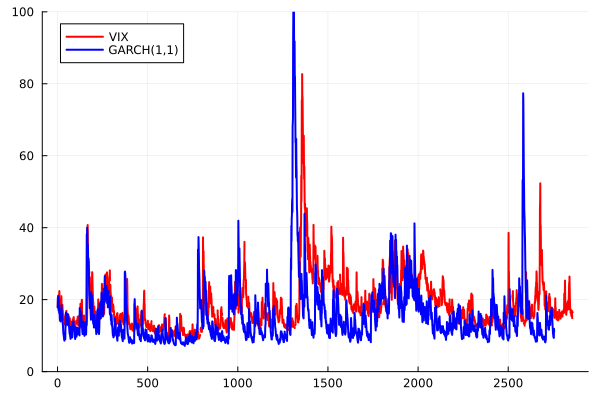

In [12]:
using Statistics
using ARCHModels
using Plots

using ARCHModels, Statistics, Plots


# σ̂_t (conditional volatility)
σ̂_t = volatilities(fit_garch)   # ARCHModels.jl accessor


# Annualised volatility (%)
vol_hat = σ̂_t .* sqrt(252) .* 100

plot(
    VIX_adjclose,
    color = :red,
    linewidth = 2,
    ylim = (0, 100),
    label = "VIX"
)

plot!(
    vol_hat,
    color = :blue,
    linewidth = 2,
    label = "GARCH(1,1)"
)